# Metrics

In [586]:
import pandas as pd
import os
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score
import functools
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

## Important functions

In [499]:
def yes_no_simetrical(value):
    if value == "yes": return "no"
    return "yes"

In [500]:
websites = pd.read_csv("../../dataset/raw_data/html.csv")

private = websites['private'].to_list()
private_details = websites['private_details'].to_list()

public = [yes_no_simetrical(x) for x in private]

yes = 0
no = 0
for i in private:
    if i == "yes":
        yes += 1
    elif i == "no":
        no +=1
    else: 
        print("others", "*"+i+"*")


In [501]:
def readFile(path):
    file = open(path, 'r', encoding='utf-8')
    content = file.read()
    file.close()
    return content

In [502]:
def get_all_prompt_size(model, data_type, context, prompt_version):
    sizes = []
    for i in range(520):
        image_size = 0
        path = '/'.join(["../prompts",model,data_type,context,prompt_version,str(i)])
        if model == "llava":
            path_image = '/'.join(["../../dataset/proccessed/html_rendered",str(i)+".png"])
            stats_image = os.stat(path_image)
            image_size = stats_image.st_size
        stats = os.stat(path)
        sizes.append(stats.st_size + image_size)
    return sizes

def get_all_results_size(model, data_type, context, prompt_version):
    sizes = []
    for i in range(520):
        path = '/'.join(["../results",model,data_type,context,prompt_version,str(i)])
        stats = os.stat(path)
        sizes.append(stats.st_size)
    return sizes

def get_all_prompt_size_average(model, data_type, context, prompt_version):
    return functools.reduce(lambda a,b: a+b, get_all_prompt_size(model, data_type, context, prompt_version)) / 520

def get_all_results_size_average(model, data_type, context, prompt_version):
    return functools.reduce(lambda a,b: a+b, get_all_results_size(model, data_type, context, prompt_version)) / 520

# get_all_prompt_size("llava", "image", "context", "0")
# get_all_results_size_average("llava", "image", "context", "0")

In [503]:
def get_results(model, data_type, context, prompt_version):
    results = []
    for i in range(520):
        path = '/'.join(["../results_processed",model,data_type,context,prompt_version,str(i)+".json"])
        content = readFile(path)
        json_value = json.loads(content)
        results.append(json_value["answer"])
    return results

def get_time(model, data_type, context, prompt_version):
    results = []
    for i in range(520):
        path = '/'.join(["../results_processed",model,data_type,context,prompt_version,str(i)+".json"])
        content = readFile(path)
        json_value = json.loads(content)
        results.append(json_value["time"])
    return results 

def get_average_time(model, data_type, context, prompt_version):
    time = get_time(model, data_type, context, prompt_version)
    total_time =  functools.reduce(lambda a, b: a+b, time)
    return total_time/520

# get_average_time("codellama", "strings", "no_context", "2")

In [504]:
def get_not_answered(results):
    counter = 0
    for i in results:
        if i == "not_answer":
            counter += 1 
    return counter    

def get_not_answered_percent(results):
    return get_not_answered(results) / 520   

def get_not_answered_model(model, data_type, context, prompt_version):
    results = get_results(model, data_type, context, prompt_version)
    return get_not_answered(results)

def get_not_answered_percent_model(model, data_type, context, prompt_version):
    results = get_results(model, data_type, context, prompt_version)
    return get_not_answered_percent(results)

# get_not_answered_model("codellama", "strings", "no_context", "2")
# get_not_answered_percent(results)



In [505]:
def total_right(results_provided, actual_results):
    counter = 0
    for i in range(520):
        if results_provided[i] == actual_results[i]:
            counter += 1
    return counter

def total_right_percent(results_provided, actual_results):
    return total_right(results_provided, actual_results) / 520

def total_right_model(model, data_type, context, prompt_version):
    results = get_results(model, data_type, context, prompt_version)
    if prompt_version == "0":
        actual_results = private
    if prompt_version == "1":
        actual_results = public
    if prompt_version == "2":
        actual_results = private_details
    return total_right(results, actual_results)

def total_right_percent_model(model, data_type, context, prompt_version):
    return total_right_model(model, data_type, context, prompt_version) / 520

In [506]:
def pop_not_answer(predicted_values, real_values):
    predicted_values_clean=[]
    real_values_clean=[]
    for i in range(520):
        a = predicted_values[i] 
        if predicted_values[i] != "not_answer":
            b = real_values[i]
            predicted_values_clean.append(a)
            real_values_clean.append(b)
    return [predicted_values_clean, real_values_clean]


def accuracy(predicted_values, real_values):
    clean = pop_not_answer(predicted_values, real_values)
    return accuracy_score(clean[0], clean[1])

def precision(predicted_values, real_values):
    clean = pop_not_answer(predicted_values, real_values)
    return precision_score(clean[0], clean[1], average="weighted")

def recall(predicted_values, real_values):
    clean = pop_not_answer(predicted_values, real_values)
    return recall_score(clean[0], clean[1], average="weighted", zero_division=0.0)

def get_all_metrics(model, data_type, context, prompt_version):
    if prompt_version == "0":
        real_values_raw = private
    if prompt_version == "1":
        real_values_raw = public
    if prompt_version == "2":
        real_values_raw = private_details

    print(model, data_type, context, prompt_version)
    print("___________________________________________")
    results = get_results(model, data_type, context, prompt_version)
    accuracy_values = accuracy(results, real_values_raw) 
    precision_values = precision(results, real_values_raw)
    recall_values = recall(results, real_values_raw)
    print("accuracy: ", accuracy_values)
    print("precision: ", precision_values)
    print("recall: ", recall_values)
    return [accuracy_values, precision_values, recall_values]

# model_results = get_results("llava", "image", "context", "0")

# get_all_metrics("llava", "image", "context", "0", private)


In [507]:
def print_total_metrics(model, data_type, context, prompt_version):
    get_all_metrics(model, data_type, context, prompt_version)
    print("average time per result(s): ", get_average_time(model, data_type, context, prompt_version))
    print("average result size (bytes): ", get_all_results_size_average(model, data_type, context, prompt_version))
    print("number not answered: ", get_not_answered_model(model, data_type, context, prompt_version))
    print("percentage not answered: ", get_not_answered_percent_model(model, data_type, context, prompt_version))
    print("percentage right predictions: ",  total_right_percent_model(model, data_type, context, prompt_version))

## llama

### html parsed

#### context 

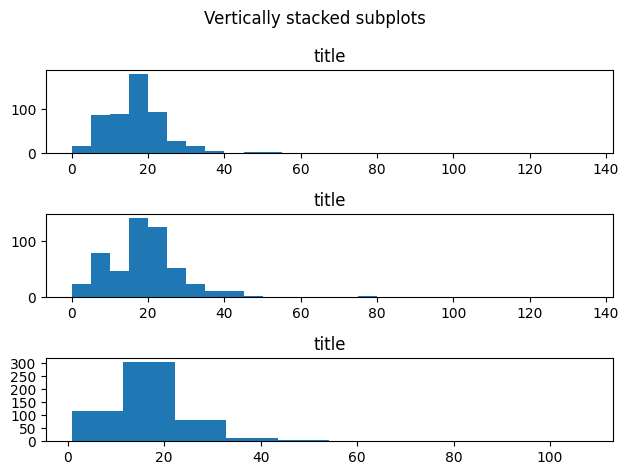

In [508]:
x = get_time("codellama","html_parsed","context","0")
y = get_time("codellama","html_parsed","context","1")
z = get_time("codellama","html_parsed","context","2")

# density = stats.gaussian_kde(x)
# plt.hist([x,y],alpha=0.5, label=['x',"y"], bins=10)
# # plt.hist(z, alpha=0.5, label='z')
# plt.legend(loc='upper right')
# plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
ax1.hist(x, bins = [t for t in range(0, 140, 5)])
ax1.set_title("title")
plt.yticks([x for x in range(0, 350, 50)])

ax2.hist(y, bins = [t for t in range(0, 140, 5)])
ax2.set_title("title")

plt.yticks([x for x in range(0, 350, 50)])
ax3.hist(z)
ax3.set_title("title")
fig.tight_layout() 

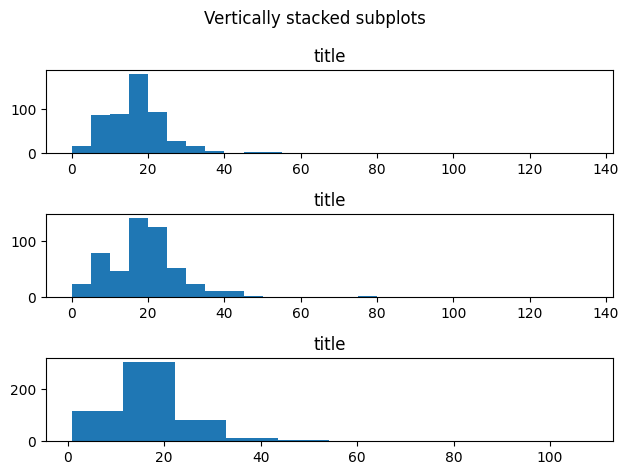

In [606]:
x = get_time("codellama","html_parsed","context","0")
y = get_time("codellama","html_parsed","context","1")
z = get_time("codellama","html_parsed","context","2")

# density = stats.gaussian_kde(x)
# plt.hist([x,y],alpha=0.5, label=['x',"y"], bins=10)
# # plt.hist(z, alpha=0.5, label='z')
# plt.legend(loc='upper right')
# plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
ax1.hist(x, bins = [t for t in range(0, 140, 5)])
ax1.set_title("title")
ax2.hist(y, bins = [t for t in range(0, 140, 5)])
ax2.set_title("title")
ax3.hist(z)
ax3.set_title("title")
fig.tight_layout() 

In [609]:
print_total_metrics("llama","html_parsed","context","0")


llama html_parsed context 0
___________________________________________
accuracy:  0.6428571428571429
precision:  0.8526687394740251
recall:  0.6428571428571429
average time per result(s):  7.079108776669229
average result size (bytes):  342.9596153846154
number not answered:  2
percentage not answered:  0.0038461538461538464
percentage right predictions:  0.6403846153846153


In [510]:
print_total_metrics("llama","html_parsed","context","1")

llama html_parsed context 1
___________________________________________
accuracy:  0.3596153846153846
precision:  1.0
recall:  0.3596153846153846
average time per result(s):  6.48077680745962
average result size (bytes):  323.67115384615386
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.3596153846153846


In [511]:
print_total_metrics("llama","html_parsed","context","2")

llama html_parsed context 2
___________________________________________
accuracy:  0.5057692307692307
precision:  0.818201103242011
recall:  0.5057692307692307
average time per result(s):  7.245863510455771
average result size (bytes):  347.4173076923077
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.5057692307692307


#### no context

In [512]:
print_total_metrics("llama","html_parsed","no_context","0")
print()

llama html_parsed no_context 0
___________________________________________
accuracy:  0.625
precision:  0.9286224727401198
recall:  0.625
average time per result(s):  6.55645339181154
average result size (bytes):  324.65384615384613
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.625



In [513]:
print_total_metrics("llama","html_parsed","no_context","1")
print()

llama html_parsed no_context 1
___________________________________________
accuracy:  0.3596153846153846
precision:  1.0
recall:  0.3596153846153846
average time per result(s):  6.356302662473078
average result size (bytes):  319.0423076923077
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.3596153846153846



In [514]:
print_total_metrics("llama","html_parsed","no_context","2")
print()

llama html_parsed no_context 2
___________________________________________
accuracy:  0.5192307692307693
precision:  0.9124396966824213
recall:  0.5192307692307693
average time per result(s):  6.414894623419234
average result size (bytes):  319.7173076923077
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.5192307692307693



### strings

#### context 

In [515]:
print_total_metrics("llama","strings","context","0")
print()

llama strings context 0
___________________________________________
accuracy:  0.6750524109014675
precision:  0.7527049947292992
recall:  0.6750524109014675
average time per result(s):  9.14692735975192
average result size (bytes):  466.09615384615387
number not answered:  43
percentage not answered:  0.08269230769230769
percentage right predictions:  0.6192307692307693



In [516]:
print_total_metrics("llama","strings","context","1")

llama strings context 1
___________________________________________


accuracy:  0.4444444444444444
precision:  0.7620173364854216
recall:  0.4444444444444444
average time per result(s):  10.276558295955766
average result size (bytes):  506.9519230769231
number not answered:  70
percentage not answered:  0.1346153846153846
percentage right predictions:  0.38461538461538464


In [517]:
print_total_metrics("llama","strings","context","2")

llama strings context 2
___________________________________________
accuracy:  0.5883495145631068
precision:  0.7116245021207014
recall:  0.5883495145631068
average time per result(s):  5.649929714699996
average result size (bytes):  352.7653846153846
number not answered:  5
percentage not answered:  0.009615384615384616
percentage right predictions:  0.5826923076923077


#### no context

In [518]:
print_total_metrics("llama","strings","no_context","0")
print()

llama strings no_context 0
___________________________________________
accuracy:  0.5254237288135594
precision:  0.549987718005404
recall:  0.5254237288135594
average time per result(s):  36.496502981296146
average result size (bytes):  1417.548076923077
number not answered:  461
percentage not answered:  0.8865384615384615
percentage right predictions:  0.05961538461538462



In [519]:
print_total_metrics("llama","strings","no_context","1")
print()

llama strings no_context 1
___________________________________________
accuracy:  0.4838709677419355
precision:  0.4743769554428741
recall:  0.4838709677419355
average time per result(s):  36.62655351256918
average result size (bytes):  1417.428846153846
number not answered:  458
percentage not answered:  0.8807692307692307
percentage right predictions:  0.057692307692307696



In [520]:
print_total_metrics("llama","strings","no_context","2")
print()

llama strings no_context 2
___________________________________________
accuracy:  0.5858585858585859
precision:  0.579180949769185
recall:  0.5858585858585859
average time per result(s):  27.563384765257677
average result size (bytes):  1109.9692307692308
number not answered:  322
percentage not answered:  0.6192307692307693
percentage right predictions:  0.2230769230769231



## codellama

### html parsed

#### context 

In [521]:
print_total_metrics("codellama","html_parsed","context","0")
print()

codellama html_parsed context 0
___________________________________________
accuracy:  0.5865384615384616
precision:  0.7347681906505437
recall:  0.5865384615384616
average time per result(s):  17.002601894967302
average result size (bytes):  679.7711538461539
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.5865384615384616



In [522]:
print_total_metrics("codellama","html_parsed","context","1")

codellama html_parsed context 1
___________________________________________
accuracy:  0.3932806324110672
precision:  0.8585944413814168
recall:  0.3932806324110672
average time per result(s):  19.541717643519227
average result size (bytes):  768.4423076923077
number not answered:  14
percentage not answered:  0.026923076923076925
percentage right predictions:  0.38269230769230766


In [523]:
print_total_metrics("codellama","html_parsed","context","2")

codellama html_parsed context 2
___________________________________________
accuracy:  0.5019230769230769
precision:  0.7510104895622198
recall:  0.5019230769230769
average time per result(s):  16.96941629260383
average result size (bytes):  670.8019230769231
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.5019230769230769


#### no context

In [524]:
print_total_metrics("codellama","html_parsed","no_context","0")
print()

codellama html_parsed no_context 0
___________________________________________


accuracy:  0.577433628318584
precision:  0.6848603435090059
recall:  0.577433628318584
average time per result(s):  16.45071845769234
average result size (bytes):  644.1096153846154
number not answered:  68
percentage not answered:  0.13076923076923078
percentage right predictions:  0.5019230769230769



In [525]:
print_total_metrics("codellama","html_parsed","no_context","1")
print()

codellama html_parsed no_context 1
___________________________________________
accuracy:  0.42032332563510394
precision:  0.7131660452273192
recall:  0.42032332563510394
average time per result(s):  17.621429051257678
average result size (bytes):  685.3519230769231
number not answered:  87
percentage not answered:  0.1673076923076923
percentage right predictions:  0.35



In [526]:
print_total_metrics("codellama","html_parsed","no_context","2")
print()

codellama html_parsed no_context 2
___________________________________________
accuracy:  0.4805447470817121
precision:  0.7984826122488808
recall:  0.4805447470817121
average time per result(s):  12.941817939748079
average result size (bytes):  550.1788461538462
number not answered:  6
percentage not answered:  0.011538461538461539
percentage right predictions:  0.475



### strings

#### context 

In [527]:
print_total_metrics("codellama","strings","context","0")
print()

codellama strings context 0
___________________________________________
accuracy:  0.5795454545454546
precision:  0.7856704526059364
recall:  0.5795454545454546
average time per result(s):  44.19396887439617
average result size (bytes):  1401.5846153846153
number not answered:  168
percentage not answered:  0.3230769230769231
percentage right predictions:  0.3923076923076923



In [528]:
print_total_metrics("codellama","strings","context","1")

codellama strings context 1
___________________________________________
accuracy:  0.46835443037974683
precision:  0.8046314329882823
recall:  0.46835443037974683
average time per result(s):  53.461540154176916
average result size (bytes):  1765.3365384615386
number not answered:  204
percentage not answered:  0.3923076923076923
percentage right predictions:  0.2846153846153846


In [529]:
print_total_metrics("codellama","strings","context","2")

codellama strings context 2
___________________________________________
accuracy:  0.49002217294900224
precision:  0.5708441605822852
recall:  0.49002217294900224
average time per result(s):  16.663737146892302
average result size (bytes):  694.2730769230769
number not answered:  69
percentage not answered:  0.1326923076923077
percentage right predictions:  0.425


#### no context

In [530]:
print_total_metrics("codellama","strings","no_context","0")
print()

codellama strings no_context 0
___________________________________________


accuracy:  0.5657894736842105
precision:  0.6913349036567942
recall:  0.5657894736842105
average time per result(s):  131.00833426478275
average result size (bytes):  3598.632692307692
number not answered:  444
percentage not answered:  0.8538461538461538
percentage right predictions:  0.08269230769230769



In [531]:
print_total_metrics("codellama","strings","no_context","1")
print()

codellama strings no_context 1
___________________________________________
accuracy:  0.4125
precision:  0.64625
recall:  0.4125
average time per result(s):  100.98291051601737
average result size (bytes):  3006.4442307692307
number not answered:  440
percentage not answered:  0.8461538461538461
percentage right predictions:  0.06346153846153846



In [532]:
print_total_metrics("codellama","strings","no_context","2")
print()

codellama strings no_context 2
___________________________________________
accuracy:  0.4911242603550296
precision:  0.6786985597224595
recall:  0.4911242603550296
average time per result(s):  106.04875717895193
average result size (bytes):  2880.9538461538464
number not answered:  351
percentage not answered:  0.675
percentage right predictions:  0.1596153846153846



## llava


### image

#### context 

In [533]:
print_total_metrics("llava","image","context","0")
print()

llava image context 0
___________________________________________
accuracy:  0.948076923076923
precision:  0.9480240833182009
recall:  0.948076923076923
average time per result(s):  10.006484586665382
average result size (bytes):  1298.6192307692309
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.948076923076923



In [534]:
print_total_metrics("llava","image","context","1")

llava image context 1
___________________________________________
accuracy:  0.47534516765285995
precision:  0.5742471335370744
recall:  0.47534516765285995
average time per result(s):  11.523758847544228
average result size (bytes):  1358.4903846153845
number not answered:  13
percentage not answered:  0.025
percentage right predictions:  0.4634615384615385


In [535]:
print_total_metrics("llava","image","context","2")

llava image context 2
___________________________________________
accuracy:  0.9596153846153846
precision:  0.9596245745052538
recall:  0.9596153846153846
average time per result(s):  224.1612084114807
average result size (bytes):  1300.3423076923077
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.9596153846153846


#### no context

In [536]:
print_total_metrics("llava","image","no_context","0")
print()

llava image no_context 0
___________________________________________
accuracy:  0.65
precision:  0.8440646528881822
recall:  0.65
average time per result(s):  8.094738927275007
average result size (bytes):  519.7423076923077
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.65



In [537]:
print_total_metrics("llava","image","no_context","1")
print()

llava image no_context 1
___________________________________________
accuracy:  0.3850687622789784
precision:  0.7315440716873928
recall:  0.3850687622789784
average time per result(s):  9.077984608353844
average result size (bytes):  545.8846153846154
number not answered:  11
percentage not answered:  0.021153846153846155
percentage right predictions:  0.3769230769230769



In [538]:
print_total_metrics("llava","image","no_context","2")
print()

llava image no_context 2
___________________________________________
accuracy:  0.5288461538461539
precision:  0.5397469849763794
recall:  0.5288461538461539
average time per result(s):  10.833071077148078
average result size (bytes):  519.1634615384615
number not answered:  0
percentage not answered:  0.0
percentage right predictions:  0.5288461538461539



## Graphics dataset

In [ ]:
#used
## private pages 
results = websites.groupby('private')['id'].nunique()
results = [results["yes"], results["no"]]

labels = ["Private Pages", "Public Pages"]

plt.pie(results, labels = labels, autopct='%1.1f%%')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distribution of Public and Private Pages')

plt.show() 


In [ ]:
# used 
## private pages 
results = websites.groupby('private_details')['id'].nunique()
results = [results["yes"], results["no"]]

labels = ["Pages With Private Details", "Pages Without Private Details"]

plt.pie(results, labels = labels, autopct='%1.1f%%')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distribution of Pages with Private Details')

plt.show() 

In [ ]:
# used 
websites_temp = websites.copy(deep=True)
websites_temp = websites_temp.drop(columns=["notes", "url", "html"])

results = websites_temp.groupby('website')['id'].nunique()

#number of websites
print("number of websites:", results.count())

results.sort_values()

results.values
plt.hist(results.values)
plt.title("Number of Pages Gathered at Each Website Distribution")
plt.xlabel("Number of Pages Gathered")
plt.ylabel("Frequency")
plt.show() 

In [ ]:
#used
def to_minutes(duration_string): 
    values = duration_string.split(":")
    return int(values[1]) + ( int(values[2]) / 60)

to_minutes("00:07:02")

In [ ]:
# used 
categories = pd.read_csv("../../dataset/raw_data/websites.csv")
categories = categories.drop(columns=["website_overview_link", "register_info"])

categories["pages / visit"].describe()


In [ ]:
#not used
# categories["visit duration"] = categories["visit duration"].apply(to_minutes)
categories["visit duration"].describe()

In [ ]:
#used
def to_number_visit(string_number):
    multiplier = 0
    if "b" in string_number: multiplier = 1000000000
    if "m" in string_number: multiplier = 1000000

    split = string_number[:-1]
    return float(split) * multiplier

to_number_visit("2.2b")

In [ ]:
#used
# categories["monthly visits"] = categories["monthly visits"].apply(to_number_visit)
print(categories["monthly visits"].sum())
categories["monthly visits"].describe()

In [ ]:
# will not be used 
categories["bounce rate"].describe()

In [551]:
#used
websites_temp = websites.copy(deep=True)
categories_temp = categories.copy(deep=True)
categories_temp =  categories_temp.drop(columns = ["monthly visits", "pages / visit", "visit duration", "bounce rate"])
# categories_temp

websites_temp = websites_temp.drop(columns=["url" , "notes", "private", "private_details", "html"])
websites_temp = websites_temp.merge(categories_temp, on="website")


In [ ]:
## used

websites_temp
results = websites_temp.groupby('category')['id'].nunique()

plot = results.plot.bar()
plot.set_title("Number of Pages per Category")
plot.set_xlabel("Categories")
plot.set_ylabel("Number of Pages")


## Prompts

11348854


Text(0.5, 1.0, 'Distribution of Size of Prompts Generated with HTML')

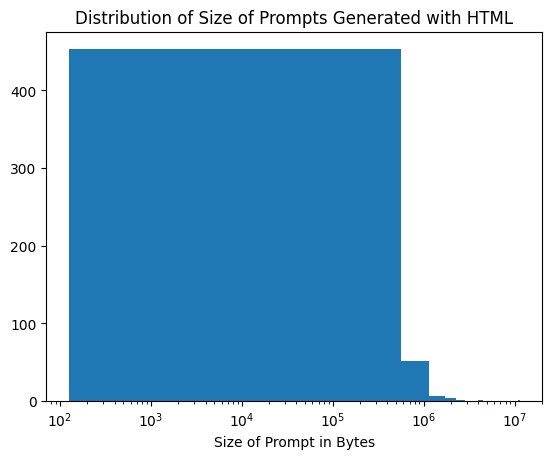

In [604]:
sizes = get_all_prompt_size("llama", "html_parsed", "no_context", "0")
print(max(sizes))
plt.hist(sizes, bins=20)
plt.xscale("log")
plt.xlabel("Size of Prompt in Bytes")
plt.title("Distribution of Size of Prompts Generated with HTML")

597875


Text(0.5, 1.0, 'Distribution of Size of Prompts Generated with Strings')

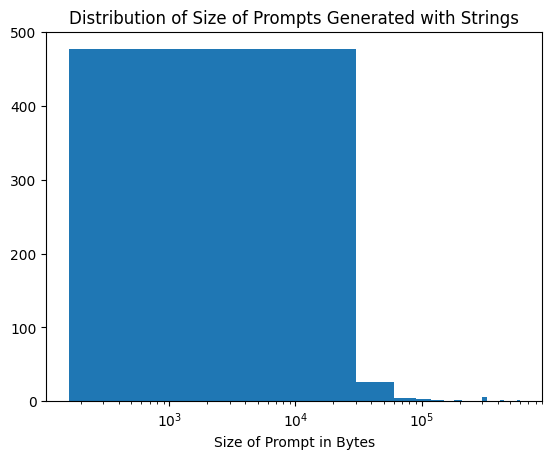

In [605]:
sizes = get_all_prompt_size("llama", "strings", "no_context", "0")
print(max(sizes))
plt.hist(sizes, bins=20)
plt.xscale("log")
plt.xlabel("Size of Prompt in Bytes")
plt.title("Distribution of Size of Prompts Generated with Strings")

98163319


Text(0.5, 1.0, 'Distribution of Size of Prompts Generated with Image')

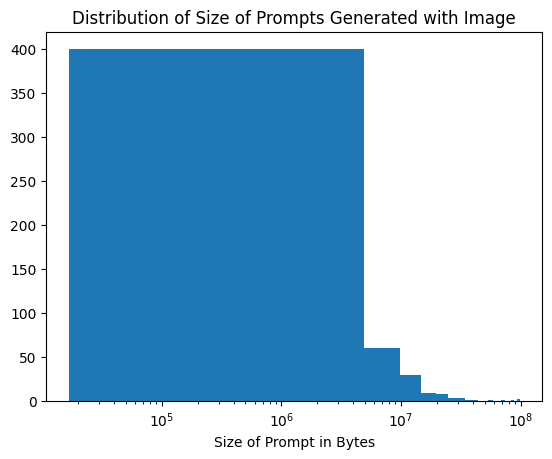

In [603]:
sizes = get_all_prompt_size("llava", "image", "no_context", "0")
print(max(sizes))
plt.hist(sizes, bins=20)
plt.xscale("log")
plt.xlabel("Size of Prompt in Bytes")
plt.title("Distribution of Size of Prompts Generated with Image")